# Análisis TI-CNN dataset
El dataset TI-CNN está compuesto por 20.015 noticias, 11.941 de las cuales son fake news, mientras que las 8.074 restantes son noticias reales. Las noticias falsas pertenecen al dataset "Getting Real About Fake News", utilizado en notebooks anteriores. Las noticias reales han sido extraídas de fuentes como New York Times y Washington Post, aunque no se indica nada más sobre su naturaleza. <br>
En el paper original, se utilizan el título, el cuerpo y las imágenes de la noticia, además de información adicional sobre ciertas propiedades de cada noticia (longitud, número de mayúsculas y minúsculas, entre otras). <br>
A pesar de estos datos adicionales, un segundo paper (Ibrain) obtiene mejores resultados empleando solamente el texto. Estos resultados son cercanos al 100% de precisión en el conjunto de pruebas.

In [52]:
# Importamos las librerías necesarias para el análisis y preprocesado del dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

# Añadimos la carpeta raíz para poder importar la clase nlp_functions
import sys
sys.path.insert(0, '../')

import nlp_functions as nlp_f

In [2]:
pd.set_option('display.max_columns', 60)

In [3]:
# Importamos el dataset sin preprocesar, debe encontrarse en la carpeta "dataset" del proyecto
df = pd.read_csv('../dataset/all_data.csv', encoding = 'utf-8')

In [4]:
# Comprobamos que el dataset se ha cargado correctamente en memoria imprimiendo sus primeras entradas
df.head(3)

,Unnamed: 0,Unnamed: 0.1,author,comments,country,crawled,domain_rank,id,language,likes,main_img_url,ord_in_thread,participants_count,published,replies_count,shares,site_url,spam_score,text,thread_title,title,type,uuid,caps_title,caps_thread,caps_text,title_len,thread_len,text_len,excl_title,excl_thread,excl_text,first_title,first_thread,first_text,second_title,second_thread,second_text,third_title,third_thread,third_text,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive,first_all,second_all,third_all
0,1,NaN,JEREMY W. PETERS,0.0,US,2017-03-14 08:25:04,0,3.0,english,0.0,https://static01.nyt.com/images/2016/11/23/us/...,0.0,0.0,2016-11-23 00:45:32,0.0,0.0,https://www.nytimes.com/2016/11/22/us/politics...,0.0,"They stood in line at Trump Tower, sometimes u...",0,"At Donald Trump<U+2019>s Properties, a Showcas...",real,f182f05dc3191ba4cb741e22f75fb43b,0,0,0,74,1,6489,0,0,0,2,0,407,0,0,150,0,0,45,9,21,5,6,20,5,14,30,14,52,409,150,45
1,2,NaN,STEVE EDER,0.0,US,2017-03-14 08:25:36,0,4.0,english,0.0,https://static01.nyt.com/images/2016/10/18/us/...,0.0,0.0,2016-10-17 18:46:52,0.0,0.0,https://www.nytimes.com/2016/10/18/us/politics...,0.0,Donald J. Trump <U+2019>s foundation informed ...,0,Trump Foundation Tells New York It Has Stopped...,real,220b87845a5eb01509b66c8008bf3728,0,0,0,75,1,2163,0,0,0,5,0,140,0,0,38,2,0,26,6,7,2,4,4,4,5,9,8,15,145,38,28
2,3,NaN,MAGGIE HABERMAN ASHLEY PARKER,0.0,US,2017-03-14 08:25:36,0,5.0,english,0.0,https://static01.nyt.com/images/2016/11/12/us/...,0.0,0.0,2016-11-12 02:08:39,0.0,0.0,https://www.nytimes.com/2016/11/12/us/politics...,0.0,President-elect Donald J. Trump won the White ...,0,"Donald Trump Prepares for White House Move, bu...",real,247e97e1da2dc67fcb31e20b84b2d960,0,0,1,74,1,6239,0,0,1,4,0,436,1,0,167,1,0,67,5,19,6,8,15,8,6,26,15,34,440,168,68


## Caracteres especiales

Los caracteres del tipo <U+2019> son símbolos como comillas para realizar citas o el genitivo sajón. La aparición de dichos caracteres no se debe a que se haya leído el fichero csv en el formato incorrecto, sino que ya aparecen en este estado en el propio fichero csv. Inicialmente se consideró eliminar estos caracteres reemplazandolos, pero afortunadamente la función de preprocesado se encarga de ellos correctamente.

In [5]:
df.title.head()

0    At Donald Trump<U+2019>s Properties, a Showcas...
1    Trump Foundation Tells New York It Has Stopped...
2    Donald Trump Prepares for White House Move, bu...
3    Luring Chinese Investors With Trump<U+2019>s N...
4    Melania and Barron Trump Won<U+2019>t Immediat...
Name: title, dtype: object

In [6]:
%%time
# Aplicamos el preprocesado a los títulos
title_preprocessed = df['title'].apply(nlp_f.tokenizer)

Wall time: 26.2 s


In [7]:
# Comprobamos que los caracteres especiales desapararecen
title_preprocessed[0:10]

0    [donald, trump, property, showcase, brand, pre...
1    [trump, foundation, tell, new, york, stop, sol...
2    [donald, trump, prepares, white, house, move, ...
3    [lure, chinese, investor, trump, name, little,...
4    [melania, barron, trump, wont, immediately, mo...
5    [ivanka, trump, presence, meet, japan, leader,...
6    [trump, lawyer, agree, settlement, talk, unive...
7    [trump, use, tower, base, fifth, avenue, grind...
8    [donald, trump, math, take, tower, great, height]
9    [trump, foundation, wont, pay, million, univer...
Name: title, dtype: object

## Columnas

In [8]:
# Posibles columnas: title, text, type
print('El dataset tiene un total de {} columnas'.format(len(df.columns)))
df.columns

El dataset tiene un total de 54 columnas


Index(['Unnamed: 0', 'Unnamed: 0.1', 'author', 'comments', 'country',
       'crawled', 'domain_rank', 'id', 'language', 'likes', 'main_img_url',
       'ord_in_thread', 'participants_count', 'published', 'replies_count',
       'shares', 'site_url', 'spam_score', 'text', 'thread_title', 'title',
       'type', 'uuid', 'caps_title', 'caps_thread', 'caps_text', 'title_len',
       'thread_len', 'text_len', 'excl_title', 'excl_thread', 'excl_text',
       'first_title', 'first_thread', 'first_text', 'second_title',
       'second_thread', 'second_text', 'third_title', 'third_thread',
       'third_text', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'sadness', 'surprise', 'trust', 'negative', 'positive', 'first_all',
       'second_all', 'third_all'],
      dtype='object')

La columna type contiene la target variable (real o fake), imprimimos los valores únicos de dicha columna para asegurarnos de que no existe una tercera categoría o valores nulos, en cuyo caso sería necesario eliminarlos antes de continuar.

In [9]:
# Target variable
df.type.unique()

array(['real', 'fake'], dtype=object)

Dos de las columnas que mas sospechas pueden levantar son las referentes al país e idioma de la noticia. Tener noticias pertenecientes a distintos países puede resultar beneficioso, ya que permitiría a los modelos neuronales entrenarse en una mayor cantidad de ámbitos informativos, extrayendo patrones característicos de las fake news independientemente del tema de la noticia. Sin embargo, la función de preprocesado y muchos de los métodos a aplicar están diseñados para textos en inglés (o en un solo idioma, aumentar el número de idiomas sería inviable con la cantidad de datos de la que se dispone), lo que provocaría que el modelo final se viera obligado a clasificar aleatoriamente los textos en idiomas distintos al inglés. O, en el peor de los casos, si se da la situación de que los textos en otro idioma se encuentren en una sola categoría, podría ocurrir que el algoritmo clasificase las noticias escritas en dicho idioma en esa categoría al detectar alguna de las palabras extranjeras, independientemente de su contenido. <br> <br>
Por estos motivos, es importante analizar que cantidad de noticias se encuentran en un idioma distinto al inglés.

In [10]:
print('Número de países: ' + str(len(df.country.unique())) + ' (también se incluye la etiqueta nocountry)\n')
print(df.country.unique())

# Podemos observar que las noticias están en 17 idiomas distintos, nos quedaremos solo con las noticias en inglés
print('\nNúmero de idiomas: ' + str(len(df.language.unique())) + ' Entre los que se incluye nan')
df.language.unique()

Número de países: 24 (también se incluye la etiqueta nocountry)

['US' 'CO' 'DE' 'GB' 'CA' 'AU' 'FR' 'EU' 'NL' 'LI' 'SG' 'ME' 'TV' 'ES'
 'RU' 'IN' 'nocountry' 'EE' 'SE' 'ZA' 'IS' 'BG' 'IR' 'CH']

Número de idiomas: 17 Entre los que se incluye nan


array(['english', 'german', 'french', 'spanish', 'russian', 'greek',
       'finnish', 'portuguese', 'arabic', 'dutch', 'italian', 'turkish',
       'ignore', 'norwegian', 'chinese', 'polish', nan], dtype=object)

Podemos ver que en el dataset existen noticias pertenecientes a 24 países distintos y en 17 idiomas diferentes. El próximo paso es analizar en que proporciones se encuentran las noticias pertenecientes a otros países y escritas en otros idiomas en cada una de las categorías.

## Separación de las noticias
Separamos las noticias en verdaderas y falsas, y procedemos a analizar las características de cada una de ellas.

In [11]:
df_real = df.loc[df['type'] == 'real']
df_fake = df.loc[df['type'] == 'fake']

In [12]:
print(df_real.type.unique())
print(df_fake.type.unique())

['real']
['fake']


Aprovechamos para comprobar que las proporciones enunciadas en el paper original son las correctas.

El dataset sin filtrar contiene un total de 8074 noticias reales
El dataset sin filtrar contiene un total de 11941 noticias falsas

------------------------------------------------------


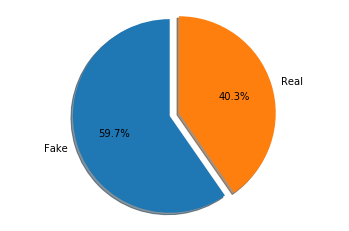

In [13]:
print('El dataset sin filtrar contiene un total de {} noticias reales'.format(len(df_real)))
print('El dataset sin filtrar contiene un total de {} noticias falsas'.format(len(df_fake)))
print('\n------------------------------------------------------')

# Pie chart
labels = 'Fake', 'Real'
sizes = [len(df_fake), len(df_real)]
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 

plt.show()

Las proporciones se cumplen

## Análisis Country

Las noticias falsas pertenecen a 24 países distintos, pero las reales solo a Estados Unidos y nocountry. En ambos casos nos damos cuenta de que las noticias pertenecientes a países distintos a Estados Unidos y Gran Bretaña son una minoría.

In [14]:
df_fake.country.unique()

array(['US', 'CO', 'DE', 'GB', 'CA', 'AU', 'FR', 'EU', 'NL', 'LI', 'SG',
       'ME', 'TV', 'ES', 'RU', 'IN', 'nocountry', 'EE', 'SE', 'ZA', 'IS',
       'BG', 'IR', 'CH'], dtype=object)

In [15]:
df_real.country.unique()

array(['US', 'nocountry'], dtype=object)

Aunque las noticias falsas provienen de mas países, nos damos cuenta de que casi todas provienen de Estados Unidos, siendo Gran Bretaña el segundo puesto.

In [16]:
df_real.country.value_counts()

US           4903
nocountry    3171
Name: country, dtype: int64

In [17]:
df_fake.country.value_counts()

US           9588
GB            727
RU            400
DE            222
TV            200
nocountry     176
EU            112
ES            100
IS            100
CA             92
NL             55
FR             51
ME             34
IN             23
BG             19
CO             17
LI             10
EE              4
ZA              3
IR              3
SG              2
SE              1
AU              1
CH              1
Name: country, dtype: int64

#### Representaciones gráficas de distribución por país

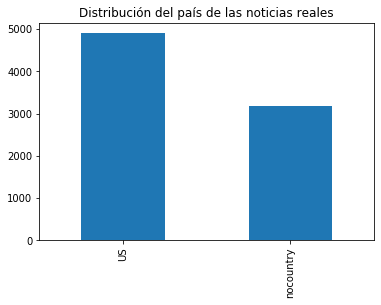

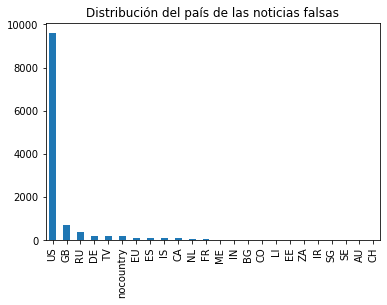

In [18]:
df_real.country.value_counts().plot(kind='bar', title = 'Distribución del país de las noticias reales')
plt.show()

df_fake.country.value_counts().plot(kind='bar', title='Distribución del país de las noticias falsas')
# plt.ylim([0,1000])
plt.show()

## Site url (Fuente de la noticia)
De acuerdo con la descripción "Getting Real About Fake News" de Kaggle, del cual se han extraído las noticias falsas, las noticias han sido extraídas de más de 200 fuentes distintas, comprobamos el número de fuentes del subconjunto de las noticias falsas.

In [19]:
len(df_fake.site_url.unique())

227

De acuerdo con el paper original, las noticias reales han sido extraídas de fuentes fiables como el New York Times y el Washington Post, pero no se dan más detalles, por lo que puede resultar interesante estudiar dichas fuentes.

Si imprimimos el número de fuentes únicas obtenemos un total de 4093, no obstante, si observamos la lista de fuentes únicas nos damos cuenta de que aparece la url completa de la noticia, por lo que no podemos tomar cada una de estas fuentes como únicas.

In [20]:
print('Número total de noticias reales: {}'.format(len(df_real)))
print('Número total de fuentes únicas (sin filtrar la url): {}'.format(len(df_real.site_url.unique())))

Número total de noticias reales: 8074
Número total de fuentes únicas (sin filtrar la url): 4903


In [21]:
# Se observa claramente que los primeros valores pertenecen al New York Times, pero se marcan como fuentes distintas por
# no ser strings idénticos
df_real['site_url'].head()

0    https://www.nytimes.com/2016/11/22/us/politics...
1    https://www.nytimes.com/2016/10/18/us/politics...
2    https://www.nytimes.com/2016/11/12/us/politics...
3    https://www.nytimes.com/2016/10/21/business/in...
4    https://www.nytimes.com/2016/11/21/us/politics...
Name: site_url, dtype: object

Ejecutamos el siguiente código para eliminar las rutas de las urls y quedarnos solamente con el dominio, también tenemos en cuenta el número de noticias que tienen un valor nulo en el campo fuente

In [23]:
fuentes = list(df_real.site_url.unique())

nan_count = df_real['site_url'].isna().sum()
print('De las ' + str(len(df_real)) + ' noticias reales ' + str(nan_count) + ' no tienen indicada una fuente\n')
# Las 4903 noticias restantes no indican la página de la fuente, sino la url completa, por lo que procedemos a eliminar
# las rutas de la url para quedarnos solo con el dominio

from urllib.parse import urlparse

fuentes_filtradas = {'nan': nan_count}

for i in fuentes:
    
    # Los valores nan son de tipo float
    if type(i) is str:
        o = urlparse(i)
    
        fuente = o.netloc
    
        if fuente not in fuentes_filtradas:
            fuentes_filtradas[fuente] = 1
        else:
            fuentes_filtradas[fuente] = fuentes_filtradas[fuente] + 1

print('Las noticias reales tienen un total de ' + str(len(fuentes_filtradas)-1) + ' fuentes conocidas\n')
print(fuentes_filtradas)

De las 8074 noticias reales 3171 no tienen indicada una fuente

Las noticias reales tienen un total de 4 fuentes conocidas

{'nan': 3171, 'www.nytimes.com': 1182, 'www.wsj.com': 2126, 'americannews.com': 159, 'www.politico.com': 1435}


La distribución de fuentes de las noticias reales puede observarse en la siguiente gráfica:

In [24]:
list(fuentes_filtradas.keys())
list(fuentes_filtradas.values())

[3171, 1182, 2126, 159, 1435]

En un 39.3% de los casos no se indica la fuente de la noticia. Dado que en el paper original la fuente no parece emplearse como parámetro de entrada de la red neuronal, este dato no es de extrañar. Ahora conocemos de manera directa cuales son las fuentes de las que provienen las noticiasa reales.

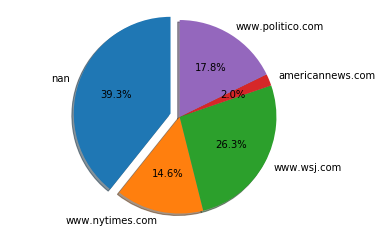

In [25]:
labels = list(fuentes_filtradas.keys())
sizes = list(fuentes_filtradas.values())
explode = (0.1, 0, 0, 0, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 

plt.show()

## Language
Analizamos la cantidad de noticias pertenecientes a cada categoría que no están en inglés

In [26]:
# Imprimir gráfica de barras
df_fake.language.unique()

array(['english', 'german', 'french', 'spanish', 'russian', 'greek',
       'finnish', 'portuguese', 'arabic', 'dutch', 'italian', 'turkish',
       'ignore', 'norwegian', 'chinese', 'polish'], dtype=object)

In [27]:
# Solo inglés y NaN, imprimir gráfica de barras
# En el caso de las noticias reales, nos quedamos con las nan, ya que suponen un total de 3171 noticias
# y, tras haber observado el dataset, se ha descubierto que están en inglés
print(df_real.language.unique())
print(len(df_real) - df_real['language'].isna().sum())
print(df_real['language'].isna().sum())

['english' nan]
4903
3171


Se observa que con el idioma ocurre lo mismo que con el país de origen, casi todas son en inglés

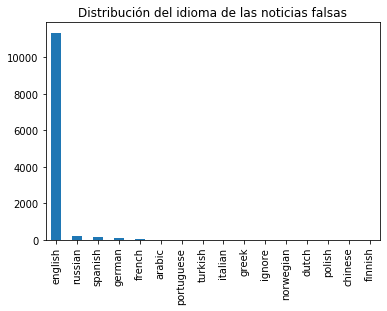

english       11349
russian         203
spanish         172
german          111
french           37
arabic           22
portuguese       11
turkish          10
italian           9
greek             4
ignore            4
norwegian         3
dutch             3
polish            1
chinese           1
finnish           1
Name: language, dtype: int64

In [28]:
df_fake.language.value_counts().plot(kind='bar', title = 'Distribución del idioma de las noticias falsas')
plt.show()

df_fake.language.value_counts()

## Filtramos por idioma
Nos quedamos solamente con el inglés y con nan

In [29]:
# Nos tenemos que quedar también con las NaN
df = df.loc[(df['language'] == 'english') | (df['language'].isna())]

Al quedarnos solamente con las noticias en inglés, el total de noticias eliminadas por estar escritas en otro idioma asciende a 592 (Apenas un 2,95%). Se ha decidido que su eliminación era necesaria porque todas las noticias escritas en idiomas distintos al inglés pertenecían al conjunto de las noticias falsas, por lo que cualquier noticia escrita en otro idioma habría sido clasificada como fake.

In [30]:
len(df)

19423

Podemos observar que, tras el filtrado, la proporción sigue manteniéndose casi idéntica.

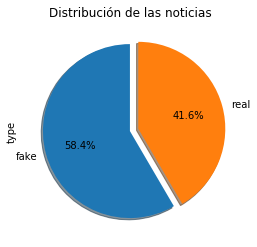

11349
8074


In [31]:
df.type.value_counts().plot(kind='pie', title = 'Distribución de las noticias', autopct='%1.1f%%', shadow=True, 
                           startangle = 90, explode = (0, 0.1))
plt.show()

fake_count = len(df.loc[df['type'] == 'fake'])
real_count = len(df.loc[df['type'] == 'real'])
print(fake_count)
print(real_count)

In [32]:
df_fake = df.loc[df['type'] == 'fake']
df_real = df.loc[df['type'] == 'real']

## Eliminación de la palabra notitle por posible sesgo
Según el paper de los creadores del dataset, la palabra más común en el caso de las fake news es notitle, que se emplea en el caso de que las noticias no tengan título. Es conveniente eliminar esta palabra, ya que esta palabra aparece con bastante más frecuencia en las noticias falsas que en las verdaderas, lo que puede ayudar a clasificar las noticias por el hecho de no tener título. <br> <br>
Dejar los títulos nulos como notitle podría considerarse una opción viable, pero creemos que la razón por la que no tienen título no se debe a la estructura de las páginas, sino a la forma en la que se ha realizado el Web Scraping sobre las mismas.

Comenzamos comprobando que no hay títulos nulos

In [33]:
# No hay ningún título nan en ninguna de las dos categorías
df['title'].isna().sum()

0

In [34]:
count_notitle_fake = len(df.loc[(df['type'] == 'fake') & (df['title'] =='notitle')])
count_notitle_real = len(df.loc[(df['type'] == 'real') & (df['title'] =='notitle')])

Puede observarse que todas las noticias reales tienen título, algo que no se cumple para las falsas (Un 5% de las noticias fake no tienen título)

In [35]:
print(count_notitle_real)
print(count_notitle_fake)

0
591


Definimos una función que aplicaremos sobre el dataset completo para eliminar la palabra notitle en el título

In [36]:
def delete_notitle(title):
    if title == 'notitle':
        return ' '
    else:
        return title

In [37]:
df['title'] = df['title'].apply(delete_notitle)

In [38]:
df.head()

,Unnamed: 0,Unnamed: 0.1,author,comments,country,crawled,domain_rank,id,language,likes,main_img_url,ord_in_thread,participants_count,published,replies_count,shares,site_url,spam_score,text,thread_title,title,type,uuid,caps_title,caps_thread,caps_text,title_len,thread_len,text_len,excl_title,excl_thread,excl_text,first_title,first_thread,first_text,second_title,second_thread,second_text,third_title,third_thread,third_text,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive,first_all,second_all,third_all
0,1,NaN,JEREMY W. PETERS,0.0,US,2017-03-14 08:25:04,0,3.0,english,0.0,https://static01.nyt.com/images/2016/11/23/us/...,0.0,0.0,2016-11-23 00:45:32,0.0,0.0,https://www.nytimes.com/2016/11/22/us/politics...,0.0,"They stood in line at Trump Tower, sometimes u...",0,"At Donald Trump<U+2019>s Properties, a Showcas...",real,f182f05dc3191ba4cb741e22f75fb43b,0,0,0,74,1,6489,0,0,0,2,0,407,0,0,150,0,0,45,9,21,5,6,20,5,14,30,14,52,409,150,45
1,2,NaN,STEVE EDER,0.0,US,2017-03-14 08:25:36,0,4.0,english,0.0,https://static01.nyt.com/images/2016/10/18/us/...,0.0,0.0,2016-10-17 18:46:52,0.0,0.0,https://www.nytimes.com/2016/10/18/us/politics...,0.0,Donald J. Trump <U+2019>s foundation informed ...,0,Trump Foundation Tells New York It Has Stopped...,real,220b87845a5eb01509b66c8008bf3728,0,0,0,75,1,2163,0,0,0,5,0,140,0,0,38,2,0,26,6,7,2,4,4,4,5,9,8,15,145,38,28
2,3,NaN,MAGGIE HABERMAN ASHLEY PARKER,0.0,US,2017-03-14 08:25:36,0,5.0,english,0.0,https://static01.nyt.com/images/2016/11/12/us/...,0.0,0.0,2016-11-12 02:08:39,0.0,0.0,https://www.nytimes.com/2016/11/12/us/politics...,0.0,President-elect Donald J. Trump won the White ...,0,"Donald Trump Prepares for White House Move, bu...",real,247e97e1da2dc67fcb31e20b84b2d960,0,0,1,74,1,6239,0,0,1,4,0,436,1,0,167,1,0,67,5,19,6,8,15,8,6,26,15,34,440,168,68
3,4,NaN,NELSON D. SCHWARTZ SUI-LEE WEE,0.0,US,2017-03-14 08:25:36,0,6.0,english,0.0,https://static01.nyt.com/images/2016/10/21/bus...,0.0,0.0,2016-10-20 22:09:04,0.0,0.0,https://www.nytimes.com/2016/10/21/business/in...,0.0,An investment pitch for a new Texas hotel is t...,0,Luring Chinese Investors With Trump<U+2019>s N...,real,e1f572512a36071cbca6056a31577389,0,0,13,59,1,7894,0,0,0,6,0,586,0,0,136,2,0,69,11,14,6,10,10,10,6,32,24,43,592,136,71
4,5,NaN,MAGGIE HABERMAN,0.0,US,2017-03-14 08:25:37,0,7.0,english,0.0,https://static01.nyt.com/images/2016/11/21/us/...,0.0,0.0,2016-11-21 01:42:23,0.0,0.0,https://www.nytimes.com/2016/11/21/us/politics...,0.0,President-elect Donald J. Trump <U+2019>s wife...,0,Melania and Barron Trump Won<U+2019>t Immediat...,real,584700e476e0d3c20731cb3d28e6ce2b,0,0,0,62,1,2979,0,0,0,7,0,216,0,0,82,1,0,27,1,12,0,3,6,2,4,14,4,25,223,82,28


In [39]:
count_notitle_fake = len(df.loc[(df['type'] == 'fake') & (df['title'] =='notitle')])
count_notitle_real = len(df.loc[(df['type'] == 'real') & (df['title'] =='notitle')])

In [40]:
print(count_notitle_fake)

0


## Preprocesado
Finalmente, realizamos los últimos preparativos para aplicar la función de preprocesado definida en el notebook ```preprocesado.ipynb```

In [41]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'author', 'comments', 'country',
       'crawled', 'domain_rank', 'id', 'language', 'likes', 'main_img_url',
       'ord_in_thread', 'participants_count', 'published', 'replies_count',
       'shares', 'site_url', 'spam_score', 'text', 'thread_title', 'title',
       'type', 'uuid', 'caps_title', 'caps_thread', 'caps_text', 'title_len',
       'thread_len', 'text_len', 'excl_title', 'excl_thread', 'excl_text',
       'first_title', 'first_thread', 'first_text', 'second_title',
       'second_thread', 'second_text', 'third_title', 'third_thread',
       'third_text', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'sadness', 'surprise', 'trust', 'negative', 'positive', 'first_all',
       'second_all', 'third_all'],
      dtype='object')

Eliminamos todas las columnas, exceptuando título, cuerpo de la noticia y tipo de noticia

In [42]:
# Nos quedamos solamente con title, text y type
df = df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'author', 'comments', 'country',
       'crawled', 'domain_rank', 'id', 'language', 'likes', 'main_img_url',
       'ord_in_thread', 'participants_count', 'published', 'replies_count',
       'shares', 'site_url', 'spam_score', 'thread_title', 
        'uuid', 'caps_title', 'caps_thread', 'caps_text', 'title_len',
       'thread_len', 'text_len', 'excl_title', 'excl_thread', 'excl_text',
       'first_title', 'first_thread', 'first_text', 'second_title',
       'second_thread', 'second_text', 'third_title', 'third_thread',
       'third_text', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'sadness', 'surprise', 'trust', 'negative', 'positive', 'first_all',
       'second_all', 'third_all'])


In [43]:
df.head()

,text,title,type
0,"They stood in line at Trump Tower, sometimes u...","At Donald Trump<U+2019>s Properties, a Showcas...",real
1,Donald J. Trump <U+2019>s foundation informed ...,Trump Foundation Tells New York It Has Stopped...,real
2,President-elect Donald J. Trump won the White ...,"Donald Trump Prepares for White House Move, bu...",real
3,An investment pitch for a new Texas hotel is t...,Luring Chinese Investors With Trump<U+2019>s N...,real
4,President-elect Donald J. Trump <U+2019>s wife...,Melania and Barron Trump Won<U+2019>t Immediat...,real


Unimos título y texto en una sola columna

In [44]:
df['text'] = df['title'] + ' ' + df['text']

Eliminamos la columna título

In [45]:
df = df.drop(columns = ['title'])

In [46]:
df.head()

,text,type
0,"At Donald Trump<U+2019>s Properties, a Showcas...",real
1,Trump Foundation Tells New York It Has Stopped...,real
2,"Donald Trump Prepares for White House Move, bu...",real
3,Luring Chinese Investors With Trump<U+2019>s N...,real
4,Melania and Barron Trump Won<U+2019>t Immediat...,real


Mapeamos los valores "real" y "fake" como 0. y 1. respectivamente

In [47]:
df.loc[df['type'] == 'fake', 'type'] = 1.
df.loc[df['type'] == 'real', 'type'] = 0.

In [48]:
df.head()

,text,type
0,"At Donald Trump<U+2019>s Properties, a Showcas...",0
1,Trump Foundation Tells New York It Has Stopped...,0
2,"Donald Trump Prepares for White House Move, bu...",0
3,Luring Chinese Investors With Trump<U+2019>s N...,0
4,Melania and Barron Trump Won<U+2019>t Immediat...,0


Aplicamos la función de preprocesado y exportamos

In [49]:
%%time
# Preprocesamos y exportamos
df['text'] = df['text'].apply(nlp_f.tokenizer)

Wall time: 10min 24s


In [50]:
df.head()

,text,type
0,"[donald, trump, property, showcase, brand, pre...",0
1,"[trump, foundation, tell, new, york, stop, sol...",0
2,"[donald, trump, prepares, white, house, move, ...",0
3,"[lure, chinese, investor, trump, name, little,...",0
4,"[melania, barron, trump, wont, immediately, mo...",0


Finalizamos exportando el dataset preprocesado como csv

In [51]:
df.to_csv('../dataset/ticnn_preprocessed.csv', index=False)